## Utils

In [17]:
import pickle as pkl
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import json
from torch.utils.data import Dataset
import torch
import random

In [5]:
def weightedMean(data, weights):
    #expects: data = array of means, weights = array of std. devs
    #computes the weighted mean with weight = 1/var^2
    n = len(data)
    sum = 0
    sum_weights = 0
    
    for i in range(len(data)):
        weight = 1 / (weights[i]**2)
        sum_weights += weight

        sum += weight * data[i]

    wmean = sum/sum_weights
    wmean_err = np.sqrt(1/sum_weights)
    return wmean, wmean_err


In [56]:
def plot_with_desi(data, err, dates, DESI_date, targetID):
    wmean, wmean_err = weightedMean(data, err)
    fig, ax = plt.subplots(1, 1, figsize = (8, 5))
    fig.suptitle(f"ZTF Magnitude with Error for {targetID}")
    ax.errorbar(dates, data, yerr = err, fmt="o", label = "ZTF Mag. w/ Error")
    ax.axhline(wmean, c = "orange", label = "Mean Mag. w/ Error")
    ax.axhline(wmean + wmean_err, c = "orange", linestyle = "--")
    ax.axhline(wmean - wmean_err, c = "orange", linestyle = "--")
    
    ax.axvline(DESI_date, c = "red", label = "DESI observation date")
    fig.legend()

In [58]:
def generate_plots(path, dates_path, n):
    load = h5py.File(path, 'r')
    dates = pd.read_hdf(dates_path)

    for i in range(n):
        field = random.choice(np.asarray(load["fields"]))
        datafile = load["fields"][field]
        while (len(np.asarray(datafile)) ==0):
            field = random.choice(np.asarray(load["fields"]))
            datafile = load["fields"][field]
            
        key = random.choice(np.asarray(datafile))

        for channel in ["g", "i", "r"]:
            obs = datafile[key][channel]
            if(len(obs) == 0):
                continue

            DESI_date = np.asarray(dates[dates["targetid"] == 39628317598419115]["mjd"])[0]
            mag = np.asarray(obs["mag"])
            magerr = np.asarray(obs["magerr"])
            date = np.asarray(obs["hmjd"])

            plot_with_desi(mag, magerr, date, DESI_date, key)

## Visualize Sample DESI Data

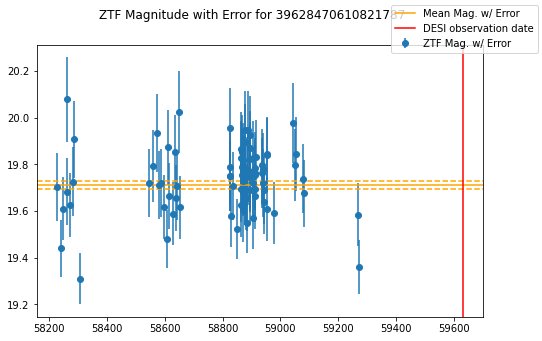

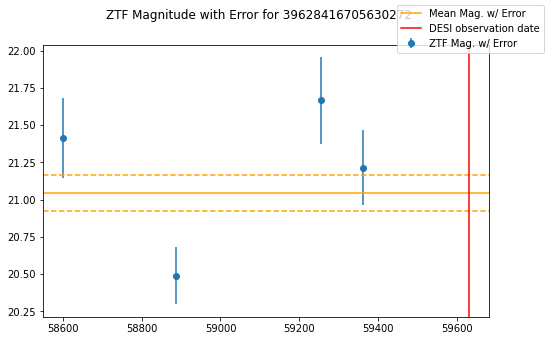

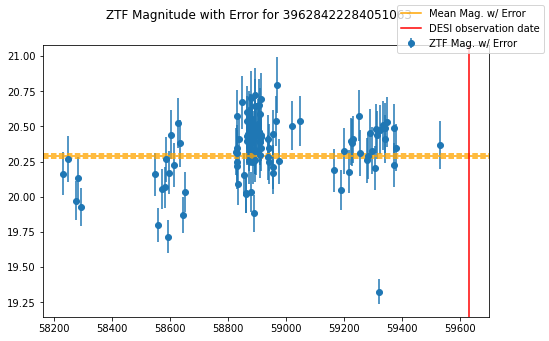

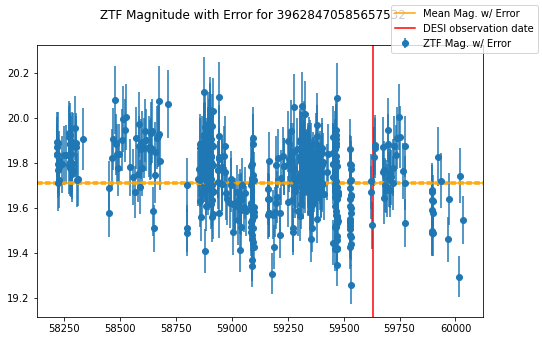

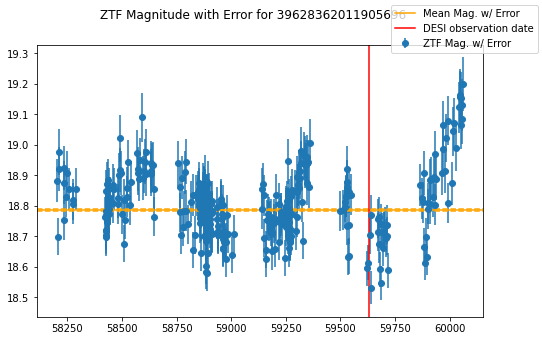

In [60]:
generate_plots("../../data/targetidLC.hdf5", "../../data/dates.hdf5", 5)

## Calculated Weighted Means

In [8]:
weightedMean(np.asarray(load["39628317598419115"]["g"]["mag"]), np.asarray(load["39628317598419115"]["g"]["magerr"]))

(21.069607680019818, 0.017893309106714866)

In [3]:
def read_ztf_from_h5py(path):
    load = h5py.File(path, 'r')
    targets = []

    def get_channel_mean(datafile, key, channel):
        ch = datafile[key][channel]
        if(len(ch) < 4):
            return None, None
        
        mag = np.asarray(ch["mag"])
        magerr = np.asarray(ch["magerr"])
        return weightedMean(mag, magerr)

    for field in load["fields"]:
        datafile = load["fields"][field]
        for key in datafile.keys():
            obs = {}
            obs["targetid"] = key
            for channel in ["g", "i", "r"]:
                mag, err = get_channel_mean(datafile, key, channel)
                obs[channel + "_mag"] = mag
                obs[channel + "_err"] = err
                
            targets.append(obs)
    return targets

In [11]:
means = read_ztf_from_h5py("../../data/targetidLC.hdf5")

with open('mean_mags.json', 'w') as f:
    json.dump(means, f)

In [13]:
with open('mean_mags.json') as f:
    means = json.load(f)

## Generate PyTorch Dataset

In [16]:
class ZTFMagDataset(Dataset):
    def __init__(self, file_path, mode="h5py"):
        if(mode == "h5py"):
            self.means = read_ztf_from_h5py(file_path)
        else:
            with open('mean_mags.json') as f:
                self.means = json.load(f)
    
    def __len__(self):
        return len(self.means)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return self.means[idx]

In [54]:
num_mult_channels = 0
for i in range(10):
    hdf_path = f"../../data/lc/00062{i}.hdf5"
    
    load = h5py.File(hdf_path, 'r')
    for key in load.keys():
        length = len(np.array(load[key]["r"])) + len(np.array(load[key]["g"])) + len(np.array(load[key]["i"]))
        if length > 4:
            num_mult_channels += 1

print(f"{num_mult_channels} targetIDs with multiple filters")


0 targetIDs with multiple filters
